<a href="https://colab.research.google.com/github/MattiaGatto/football-match-betting-predictions/blob/main/prediction_result_of_football_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che predice il risultato delle partite della serie A

---
# Librerie necessarie all'utilizzo

In [1]:
!pip install --upgrade pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from datetime import date
from bs4 import BeautifulSoup
from google.colab import drive
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load 
from pathlib import Path
from sklearn.metrics import mean_squared_error
import time
import urllib
import csv
import datetime
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
drive.mount('/content/drive')

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Data extraction
## Riceverò i dati attraverso il seguente url.



In [2]:
URL = "https://www.football-data.co.uk/italym.php"
resp = requests.get(URL)
print(resp.status_code)

200


In [3]:
# creazione di un oggetto "soup"
data = BeautifulSoup(resp.content)

def Dataframe_RES(path):
  try:
    res = urllib.request.urlopen('https://www.football-data.co.uk/'+path)
    df = pd.read_csv(res)
    return df
  except:
    error.append('https://www.football-data.co.uk/'+path)
    # print("An exception occurred")

error=[]
SERIE_A=[]
SERIE_B=[]
for link in data.find_all('a'):
  l=link.get('href')
  if (str(l)[len(l)-4:]==".csv"):
    path=str(link.get('href'))
    # print(path,path[len(path)-6:len(path)-4])
    if (path[len(path)-6:len(path)-4]=='I1'):
      SERIE_A.append(Dataframe_RES(path))
      # print('SERIE_A')
    if (path[len(path)-6:len(path)-4]=='I2'):
      SERIE_B.append(Dataframe_RES(path))
      # print('SERIE_B')

# print(len(error))
for e in error:
  res = urllib.request.urlopen(e)
  df = pd.read_csv(res, encoding ='latin1', error_bad_lines=False)
  if (e[len(e)-6:len(e)-4]=='I1'):
      SERIE_A.append(df)
      # print('SERIE_A')
  if (e[len(e)-6:len(e)-4]=='I2'):
    SERIE_B.append(df)
    # print('SERIE_B')

b'Skipping line 177: expected 49 fields, saw 51\nSkipping line 178: expected 49 fields, saw 51\nSkipping line 179: expected 49 fields, saw 51\nSkipping line 180: expected 49 fields, saw 51\nSkipping line 181: expected 49 fields, saw 51\nSkipping line 182: expected 49 fields, saw 51\nSkipping line 183: expected 49 fields, saw 51\nSkipping line 184: expected 49 fields, saw 51\nSkipping line 185: expected 49 fields, saw 51\nSkipping line 186: expected 49 fields, saw 51\nSkipping line 187: expected 49 fields, saw 51\nSkipping line 188: expected 49 fields, saw 51\nSkipping line 189: expected 49 fields, saw 51\nSkipping line 190: expected 49 fields, saw 51\nSkipping line 191: expected 49 fields, saw 51\nSkipping line 192: expected 49 fields, saw 51\nSkipping line 193: expected 49 fields, saw 50\nSkipping line 194: expected 49 fields, saw 50\nSkipping line 195: expected 49 fields, saw 50\nSkipping line 196: expected 49 fields, saw 50\nSkipping line 197: expected 49 fields, saw 50\nSkipping li

Note per i dati di calcio

Tutti i dati sono in formato csv, pronti per l'uso all'interno di applicazioni di fogli di calcolo standard. Si prega di notare che alcune abbreviazioni non sono più in uso (in particolare le quote di specifici bookmaker non più utilizzate) e si riferiscono ai dati raccolti nelle stagioni precedenti. Per un elenco aggiornato di quali bookmaker sono inclusi nel set di dati, visitare http://www.football-data.co.uk/matches.php

Chiave per i dati dei risultati:

- Div = Divisione League

- Date = Data della partita (gg/mm/aa)

- Time = Momento del calcio d'inizio della partita

- HomeTeam = Squadra di casa

- AwayTeam = Squadra ospite

- FTHG and HG = Obiettivi della squadra di casa a tempo pieno

- FTAG and AG = Obiettivi di squadra in trasferta a tempo pieno

- FTR and Res = Risultato a tempo pieno (h=vittoria in casa, D=pareggio, a=vittoria in trasferta)

- HTHG = Gol della squadra di casa a metà tempo

- HTAG = Gol di squadra in trasferta a metà tempo

- HTR = Risultato del primo tempo (h=vittoria in casa, D=pareggio, a=vittoria in trasferta)

Statistiche delle partite (ove disponibili)

- Attendance = Affluenza alla folla

- Referee = Arbitro della partita

- HS = Colpi della squadra di casa

- AS = Tiri in trasferta

- HST = Colpi della squadra di casa sul bersaglio

- AST = Tiri in trasferta sul bersaglio

- HHW = Home Team Hit Woodwork

- AHW = Squadra in trasferta Hit Woodwork

- HC = Corner della squadra di casa

- AC = Angoli della squadra in trasferta

- HF = Fallo commesso dalla squadra di casa

- AF = Falli commessi in trasferta

- HFKC = Calci di punizione concessi dalla squadra di casa

- AFKC = Calci di punizione concessi dalla squadra ospite

- HO = Fuorigioco della squadra di casa

- AO = Fuorigioco della squadra in trasferta

- HY = Cartellini gialli della squadra di casa

- AY = Cartellini gialli della squadra ospite

- HR = Cartellini rossi della squadra di casa

- AR = Cartellini rossi della squadra in trasferta

- HBP = Home Team Bookings Points (10 = giallo, 25 = rosso)

- ABP = Punti Prenotazioni Squadre Away (10 = giallo, 25 = rosso)

Si noti che i calci di punizione conceeded includono falli, fuorigioco e qualsiasi altra offesa commessa e saranno sempre uguali o superiori al numero di falli. I falli costituiscono la stragrande maggioranza dei calci di punizione concessi. I calci di punizione concessi vengono mostrati quando non sono disponibili dati specifici sui falli (Francia 2a, Belgio 1a e Grecia 1a divisione).

Si noti inoltre che i cartellini gialli inglesi e scozzesi non includono il cartellino giallo iniziale quando un secondo viene mostrato a un giocatore che lo converte in rosso, ma questo è incluso come giallo (più rosso) per le partite europee.


Chiave per i dati sulle quote di scommessa 1X2 (partita):


- B365H = Bet365 quote vittoria in casa

- B365D = Quote di estrazione Bet365

- B365A = Bet365 quote vittoria in trasferta

- BSH = Blue Square quote di vittoria in casa

- BSD = Quote di estrazione Blue Square

- BSA = Blue Square quote di vittoria in trasferta

- BWH = Quote di vincita in casa Bet&Win

- BWD = Quote di estrazione Bet&Win

- BWA = Quote di vincita in trasferta Bet&Win

- GBH = Quote di vincita in casa di Gamebookers

- GBD = Quote di sorteggio Gamebookers

- GBA = Quote di vincita in trasferta dei Gamebookers

- IWH = Quote di vittoria in casa Interwetten

- IWD = Quote di pareggio Interwetten

- IWA = Quote di vittoria in trasferta interwetten

- LBH = Ladbrokes quote di vittoria in casa

- LBD = Quote di estrazione di Ladbrokes

- LBA = Ladbrokes in trasferta quote di vittoria

- PSH e PH = Pinnacle quote di vittoria in casa

- PSD e PD = Quote di pareggio Pinnacle

- PSA e PA = Pinnacle quote di vittoria in trasferta

- SOH = Sporting Odds quote vittoria in casa

- SOD = Quote sportive quote di estrazione

- SOA = Quote Sportive quote vittoria in trasferta

- SBH = Sportingbet quote di vittoria in casa

- SBD = Quote di pareggio Sportingbet

- SBA = Sportingbet quote vittoria in trasferta

- SJH = Stan James quote di vittoria in casa

- SJD = Stan James pareggio quote

- SJA = Stan James in trasferta quote vittoria

- SYH = Stanleybet quote di vittoria in casa

- SYD = Stanleybet quote di pareggio

- SYA = Stanleybet in trasferta quote di vittoria

- VCH = VC Bet quote di vincita in casa

- VCD = Vc Bet quote di estrazione

- VCA = VC Bet quote di vincita in trasferta

- WHH = William Hill quote vittoria in casa

- WHD = William Hill quote di pareggio

- WHA = William Hill in trasferta quote vittoria

- Bb1X2 = Numero di bookmaker BetBrain utilizzati per calcolare le medie e i massimi delle quote delle partite

- BbMxH = Betbrain massimo di vincita in casa

- BbAvH = Betbrain probabilità medie di vittoria in casa

- BbMxD = Betbrain quote di pareggio massimo

- BbAvD = Betbrain media delle quote di vincita

- BbMxA = Betbrain massimo di vittorie in trasferta

- BbAvA = Betbrain media di vittorie in trasferta

- MaxH = Quote di vincita in casa massime del mercato

- MaxD = Quote di vincita massima del pareggio di mercato

- MaxA = Quote di vincita in trasferta massime del mercato

- AvgH = Probabilità di vincita in casa medie di mercato

- AvgD = Quote di vincita medie del mercato

- AvgA = Quote di vincita in trasferta medie di mercato



Chiave per le quote totali di scommessa sugli obiettivi:


- BbOU = Numero di bookmaker BetBrain utilizzati per calcolare medie e massimi di over/under 2,5 goal (goal totali)

- BbMx>2.5 = Betbrain massimo oltre 2.5 goal

- BbAv>2.5 = Betbrain media oltre 2.5 gol

- BbMx<2.5 = Betbrain massimo sotto i 2.5 gol

- BbAv<2.5 = Betbrain media sotto i 2.5 gol



- GB>2.5 = Gamebookers oltre 2.5 gol

- GB<2.5 = Gamebookers sotto i 2,5 gol

- B365>2.5 = Bet365 oltre 2.5 gol

- B365<2.5 = Bet365 sotto i 2,5 gol

- P>2.5 = Pinnacle oltre 2.5 gol

- P<2.5 = Pinnacle sotto i 2,5 gol

- Max>2.5 = Massimo di mercato oltre 2,5 obiettivi

- Max<2.5 = Massimo di mercato sotto i 2,5 obiettivi

- Avg>2.5 = Media di mercato superiore a 2,5 gol

- Avg <2,5 = Media di mercato inferiore a 2,5 gol




Chiave per le quote di scommesse con handicap asiatico:

- BbAH = Numero di bookmaker BetBrain utilizzati per medie e massimi di handicap asiatici

- BbAHh = Betbrain dimensione dell'handicap (squadra di casa)

- AHh = Dimensione del mercato dell'handicap (squadra di casa) (dal 2019/2020)

- BbMxAHH = Betbrain massimo asiatico handicap squadra di casa quote

- BbAvAHH = Betbrain media asiatica handicap squadra di casa quote

- BbMxAHA = Betbrain massimo handicap asiatico in trasferta quote squadra

- BbAvAHA = Betbrain media asiatica handicap in trasferta quote squadra



- GBAHH = Quote della squadra di casa con handicap asiatico gamebookers

- GBAHA = Quote squadra in trasferta handicap asiatico Gamebookers

- GBAH = Gamebookers dimensione dell'handicap (squadra di casa)

- LBAHH = Ladbrokes Asian handicap squadra di casa quote

- LBAHA = Ladbrokes Asian handicap away team odds

- LBAH = Ladbrokes dimensione dell'handicap (squadra di casa)

- B365AHH = Bet365 Asian handicap home team quote

- B365AHA = Bet365 Asian handicap quote squadra in trasferta

- B365AH = Bet365 dimensione dell'handicap (squadra di casa)

- PAHH = Pinnacle Asian handicap squadra di casa quote

- PAHA = Pinnacle Asian handicap quote squadra in trasferta

- MaxAHH = Quote di squadra di casa con handicap asiatico massimo di mercato

- MaxAHA = Quote di squadra in trasferta con handicap asiatico massimo di mercato	

- AvgAHH = Quote medie di mercato della squadra di casa asiatica

- AvgAHA = Quote medie di mercato della squadra asiatica handicap in trasferta



Quote di chiusura (ultime quote prima dell'inizio della partita)

Come sopra ma con un carattere "C" aggiuntivo che segue l'abbreviazione del bookmaker / Max / Avg

Football-Data desidera riconoscere le seguenti fonti che sono state utilizzate nella compilazione dei risultati e dei file delle quote di Football-Data.


Risultati attuali (tempo pieno, metà tempo)
XScores - http://www.xscores .com

Statistiche delle partite
BBC, ESPN Soccer, Bundesliga.de, Gazzetta.it e Football.fr

Quote scommesse bookmakers
Bookmaker individuali

Le quote di scommessa per le partite del fine settimana vengono raccolte il venerdì pomeriggio e il martedì pomeriggio per le partite infrasettimanali.

Ulteriori statistiche delle partite (corner, tiri, prenotazioni, arbitro, ecc.) per le stagioni 2000/01 e 2001/02 per i campionati inglese, scozzese e tedesco sono state fornite da Sports.com (ora sotto nuova proprietà e non più disponibile).



In [4]:
ds_serieA=SERIE_A[0]
for da in SERIE_A[1:]:
  ds_serieA=ds_serieA.append(da, ignore_index=True).reset_index(drop=True)
ds_serieB=SERIE_B[0]
for db in SERIE_B[1:]:
  ds_serieB=ds_serieB.append(db, ignore_index=True).reset_index(drop=True)
ds_serieB

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 33,Unnamed: 34,Unnamed: 35,SYH,SYD,SYA
0,I2,12/08/2022,19:45,Parma,Bari,2.0,2.0,D,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I2,13/08/2022,19:45,Cittadella,Pisa,4.0,3.0,H,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I2,13/08/2022,19:45,Como,Cagliari,1.0,1.0,D,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I2,13/08/2022,19:45,Palermo,Perugia,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I2,14/08/2022,19:45,Ascoli,Ternana,2.0,1.0,H,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,I2,02/06/02,NaN,Modena,Salernitana,5.0,2.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10197,I2,02/06/02,NaN,Napoli,Como,1.0,2.0,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10198,I2,02/06/02,NaN,Palermo,Ancona,2.0,3.0,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10199,I2,02/06/02,NaN,Reggina,Genoa,2.0,2.0,D,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
matches=ds_serieA.append(ds_serieB, ignore_index=True).reset_index(drop=True)

---
# Data Preparation

In [6]:
x=matches.isnull().sum()
eliminate=[]

In [7]:
count=0
for col in range (len(x)):
  if(x[col]>=len(matches)-1000):
    count+=1
    matches=matches.drop([x.keys()[col]],axis=1)
    eliminate.append(x.keys()[col])
print('count=',count)

count= 57


In [8]:
matches['FTR']

0        H
1        A
2        A
3        A
4        H
        ..
21564    H
21565    A
21566    A
21567    D
21568    A
Name: FTR, Length: 21569, dtype: object

In [9]:
matches['risultato']=matches['FTR']
matches['risultato'][matches['risultato']=="A"]="2"
matches['risultato'][matches['risultato']=="D"]="X"
matches['risultato'][matches['risultato']=="H"]="1"
# matches

In [10]:
dataset=matches[["Date","HomeTeam","AwayTeam","B365H","B365D","B365A","BWH","BWD","BWA","IWH","IWD","IWA","PSH","PSD","PSA","WHH","WHD","WHA","VCH","VCD","VCA","risultato"]]
dataset=dataset.dropna()
dataset

,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,risultato
0,13/08/2022,Milan,Udinese,1.44,4.75,7.00,1.41,4.75,7.50,1.40,...,1.43,4.66,8.84,1.38,4.60,8.50,1.36,4.6,9.00,1
1,13/08/2022,Sampdoria,Atalanta,4.33,3.90,1.75,4.33,3.80,1.77,4.30,...,4.72,3.98,1.78,4.50,3.80,1.73,4.75,3.7,1.73,2
2,13/08/2022,Lecce,Inter,10.00,5.75,1.28,9.75,5.50,1.30,9.50,...,10.75,5.92,1.31,11.00,5.50,1.27,12.00,5.5,1.25,2
3,13/08/2022,Monza,Torino,2.60,3.30,2.75,2.55,3.25,2.80,2.60,...,2.64,3.36,2.90,2.50,3.25,2.80,2.55,3.1,2.88,2
4,14/08/2022,Fiorentina,Cremonese,1.36,5.00,8.50,1.39,4.80,7.75,1.40,...,1.39,5.33,8.49,1.36,4.60,9.00,1.33,4.8,9.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20651,11/05/2019,Padova,Livorno,6.50,3.80,1.55,5.75,3.60,1.60,5.60,...,5.90,3.87,1.62,6.00,3.80,1.55,6.50,3.8,1.60,X
20652,11/05/2019,Palermo,Cittadella,1.66,3.50,5.50,1.67,3.60,5.00,1.70,...,1.77,3.47,5.28,1.70,3.60,5.00,1.73,3.6,5.20,X
20653,11/05/2019,Perugia,Cremonese,2.25,3.10,3.40,2.20,3.10,3.25,2.15,...,2.31,3.28,3.34,2.20,3.20,3.25,2.25,3.2,3.40,1
20654,11/05/2019,Pescara,Salernitana,2.15,3.20,3.50,2.30,3.10,3.10,2.15,...,2.27,3.16,3.57,2.15,3.25,3.40,2.20,3.3,3.40,1


In [11]:
new_date=[]
for date in dataset['Date']:
  date_string = str(date)
  timestamp=0.0
  try:
    timestamp = time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple())
  except:
    date_string=date_string[:len(date_string)-2]+'20'+date_string[len(date_string)-2:]
    timestamp = time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple())
  new_date.append(timestamp)
dataset['Date']=new_date

In [12]:
list_home_team=dataset['HomeTeam'].unique()
list_home_team.sort()
list_away_team=dataset['AwayTeam'].unique()
list_away_team.sort()
print(list_away_team==list_home_team)
team_dict=dict(zip(list_home_team,np.arange(len(list_home_team))))
for k in team_dict:
  dataset['HomeTeam'][matches['HomeTeam']==k]=team_dict[k]
  dataset['AwayTeam'][matches['AwayTeam']==k]=team_dict[k]

dataset

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,risultato
0,1.660349e+09,31,57,1.44,4.75,7.00,1.41,4.75,7.50,1.40,...,1.43,4.66,8.84,1.38,4.60,8.50,1.36,4.6,9.00,1
1,1.660349e+09,48,2,4.33,3.90,1.75,4.33,3.80,1.77,4.30,...,4.72,3.98,1.78,4.50,3.80,1.73,4.75,3.7,1.73,2
2,1.660349e+09,29,24,10.00,5.75,1.28,9.75,5.50,1.30,9.50,...,10.75,5.92,1.31,11.00,5.50,1.27,12.00,5.5,1.25,2
3,1.660349e+09,33,55,2.60,3.30,2.75,2.55,3.25,2.80,2.60,...,2.64,3.36,2.90,2.50,3.25,2.80,2.55,3.1,2.88,2
4,1.660435e+09,19,16,1.36,5.00,8.50,1.39,4.80,7.75,1.40,...,1.39,5.33,8.49,1.36,4.60,9.00,1.33,4.8,9.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20651,1.557533e+09,36,30,6.50,3.80,1.55,5.75,3.60,1.60,5.60,...,5.90,3.87,1.62,6.00,3.80,1.55,6.50,3.8,1.60,X
20652,1.557533e+09,37,13,1.66,3.50,5.50,1.67,3.60,5.00,1.70,...,1.77,3.47,5.28,1.70,3.60,5.00,1.73,3.6,5.20,X
20653,1.557533e+09,39,16,2.25,3.10,3.40,2.20,3.10,3.25,2.15,...,2.31,3.28,3.34,2.20,3.20,3.25,2.25,3.2,3.40,1
20654,1.557533e+09,40,47,2.15,3.20,3.50,2.30,3.10,3.10,2.15,...,2.27,3.16,3.57,2.15,3.25,3.40,2.20,3.3,3.40,1


In [13]:
labels=['1','2','X']
print(dataset['risultato'].value_counts())

1    3440
X    2273
2    2235
Name: risultato, dtype: int64


In [14]:
X=dataset.drop('risultato',axis=1)
Y=dataset['risultato']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30,stratify=Y, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.33,stratify=y_test, random_state=42)

y_train=y_train.astype('str')
y_validation=y_validation.astype('str')
y_test=y_test.astype('str')

In [15]:
print(y_train.value_counts())

1    2408
X    1591
2    1564
Name: risultato, dtype: int64


In [16]:
scaler=StandardScaler()
x_train=pd.DataFrame(scaler.fit_transform(x_train))
x_validation=pd.DataFrame(scaler.transform(x_validation))
x_test=pd.DataFrame(scaler.transform(x_test))

---
# MODEL TRAINING

In [17]:
#caricamento 
def load_model(model_path, model):
    model=load(model_path)
    return model

#salvataggio
def save_model(model,model_path):
    dump(model,model_path)
    return model
    
def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
          esiste=True
    except IOError:
        print("File not accessible")
    print("Il modello addestrato esiste?",esiste)
    return esiste

## SVM

In [18]:
from sklearn.svm import SVC

In [19]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_SVM_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_SVM_Scaler_ep.model
Il modello addestrato esiste? True


In [20]:
# SVC
if exist_model==False:
  model_SVC=SVC()
  # define the ovr strategy
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC.fit(x_train, y_train)
  ovr_SVC=save_model(ovr_SVC,path_name)
else:
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC=load_model(path_name, ovr_SVC)

In [21]:
y_pred_SVC=ovr_SVC.predict(x_validation)
print(accuracy_score(y_validation,y_pred_SVC))
print(classification_report(y_validation,y_pred_SVC))

0.5034439574201628
              precision    recall  f1-score   support

           1       0.53      0.80      0.64       691
           2       0.50      0.46      0.48       449
           X       0.33      0.10      0.15       457

    accuracy                           0.50      1597
   macro avg       0.45      0.45      0.42      1597
weighted avg       0.46      0.50      0.45      1597



## RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_RandomForestClassifier_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_RandomForestClassifier_Scaler_ep.model
Il modello addestrato esiste? True


In [24]:
# RandomForest
if exist_model==False:
  model_RandomForest=RandomForestClassifier()
  # define the ovr strategy
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest.fit(x_train, y_train)
  ovr_RandomForest=save_model(ovr_RandomForest,path_name)
else:
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=load_model(path_name, ovr_RandomForest)

In [25]:
y_pred_RandomForest=ovr_RandomForest.predict(x_validation)
print(accuracy_score(y_validation,y_pred_RandomForest))
print(classification_report(y_validation,y_pred_RandomForest))

0.8359423919849718
              precision    recall  f1-score   support

           1       0.82      0.91      0.86       691
           2       0.84      0.84      0.84       449
           X       0.87      0.72      0.79       457

    accuracy                           0.84      1597
   macro avg       0.84      0.82      0.83      1597
weighted avg       0.84      0.84      0.83      1597



## DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_DecisionTree_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_DecisionTree_Scaler_ep.model
Il modello addestrato esiste? True


In [28]:
# DecisionTree
if exist_model==False:
  model_DecisionTree=DecisionTreeClassifier()
  # define the ovr strategy
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree.fit(x_train, y_train)
  ovr_DecisionTree=save_model(ovr_DecisionTree,path_name)
else:
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree=load_model(path_name, ovr_DecisionTree)

In [29]:
y_pred_DecisionTree=ovr_DecisionTree.predict(x_validation)
print(accuracy_score(y_validation,y_pred_DecisionTree))
print(classification_report(y_validation,y_pred_DecisionTree))

0.728240450845335
              precision    recall  f1-score   support

           1       0.89      0.69      0.78       691
           2       0.76      0.66      0.71       449
           X       0.58      0.85      0.69       457

    accuracy                           0.73      1597
   macro avg       0.74      0.73      0.72      1597
weighted avg       0.77      0.73      0.73      1597



## kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_KNearestNeighbors_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_KNearestNeighbors_Scaler_ep.model
Il modello addestrato esiste? True


In [32]:
# kNN
if exist_model==False:
  model_kNN=KNeighborsClassifier()
  # define the ovr strategy
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN.fit(x_train, y_train)
  ovr_kNN=save_model(ovr_kNN,path_name)
else:
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN=load_model(path_name, ovr_kNN)

In [33]:
y_pred_kNN=ovr_kNN.predict(x_validation)
print(accuracy_score(y_validation,y_pred_kNN))
print(classification_report(y_validation,y_pred_kNN))

0.5466499686912962
              precision    recall  f1-score   support

           1       0.65      0.58      0.61       691
           2       0.55      0.53      0.54       449
           X       0.43      0.50      0.46       457

    accuracy                           0.55      1597
   macro avg       0.54      0.54      0.54      1597
weighted avg       0.56      0.55      0.55      1597



## AdaBoost Classifier



In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_AdaBoostClassifier_Scaler_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_AdaBoostClassifier_Scaler_ep.model
Il modello addestrato esiste? True


In [36]:
# AdaBoostClassifier
if exist_model==False:
  model_AdaBoost=AdaBoostClassifier()
  # define the ovr strategy
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost.fit(x_train, y_train)
  ovr_AdaBoost=save_model(ovr_AdaBoost,path_name)
else:
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost=load_model(path_name, ovr_AdaBoost)

In [37]:
y_pred_AdaBoost=ovr_AdaBoost.predict(x_validation)
print(accuracy_score(y_validation,y_pred_AdaBoost))
print(classification_report(y_validation,y_pred_AdaBoost))

0.5059486537257357
              precision    recall  f1-score   support

           1       0.53      0.79      0.64       691
           2       0.47      0.51      0.49       449
           X       0.40      0.08      0.13       457

    accuracy                           0.51      1597
   macro avg       0.47      0.46      0.42      1597
weighted avg       0.48      0.51      0.45      1597



## Neural Networks



In [38]:
from tensorflow import keras

In [39]:
#Costruiamo il network model
def Neural_network_model():
  model = keras.Sequential([
    keras.layers.Dense(32,input_dim=21,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(3,activation='softmax')
  ])
  return model

model=Neural_network_model()

#Compila il modello model.compile
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
y_train_enc=pd.get_dummies(y_train)
y_validation_enc=pd.get_dummies(y_validation)
y_test_enc=pd.get_dummies(y_test)

In [41]:
epochs=500
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_NNClassifier_Scaler_"+str(epochs)+"_ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_NNClassifier_Scaler_500_ep.model
Il modello addestrato esiste? True


In [42]:
# NeuralNet
if exist_model==False:
  history=model.fit(x_train,y_train_enc, epochs=epochs,validation_split=0.2)
  history=save_model(history,path_name)
else:
  history=load_model(path_name, model)

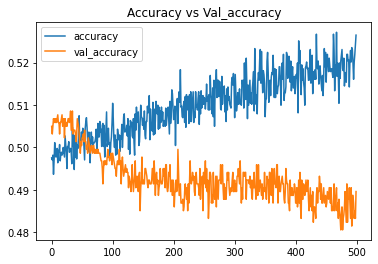

In [43]:
plt.plot(history.history['accuracy'],label="accuracy")
plt.plot(history.history['val_accuracy'],label="val_accuracy")
plt.legend(loc="upper left")
plt.title('Accuracy vs Val_accuracy')
plt.show()

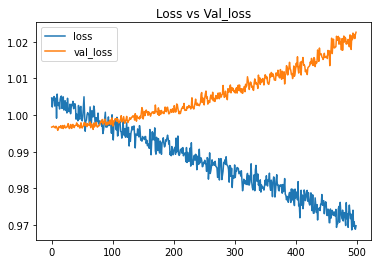

In [44]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend(loc="upper left")
plt.title('Loss vs Val_loss')
plt.show()

In [45]:
y_pred_NN=model.predict(x_validation)
y_pred_NN=np.argmax(y_pred_NN,axis=1)
y_pred_NN_enc=pd.get_dummies(y_pred_NN)
print(len(y_pred_NN_enc.columns))
if len(y_pred_NN_enc.columns)<=1:
  y_pred_NN_enc[2]=0
  y_pred_NN_enc[3]=0
if len(y_pred_NN_enc.columns)<=2:
  y_pred_NN_enc[3]=0
print(accuracy_score(y_validation_enc,y_pred_NN_enc))
print(classification_report(y_validation_enc,y_pred_NN_enc))

50/50 [==============================] - 1s 3ms/step
3
0.4107701941139637
              precision    recall  f1-score   support

           0       0.44      0.87      0.59       691
           1       0.18      0.01      0.01       449
           2       0.23      0.11      0.15       457

   micro avg       0.41      0.41      0.41      1597
   macro avg       0.28      0.33      0.25      1597
weighted avg       0.31      0.41      0.30      1597
 samples avg       0.41      0.41      0.41      1597



---
# Confronto su un nuovo dataset di Test per determinare il classificatore migliore

In [46]:
ris_model=dict()

y_pred_SVC_test=ovr_SVC.predict(x_test)
acc_prediction_SVC=accuracy_score(y_test,y_pred_SVC_test)
classification_report_prediction_SVC=classification_report(y_test,y_pred_SVC_test)
weighted_avg_SVC=float(classification_report_prediction_SVC.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nSVC\naccuracy:",acc_prediction_SVC,"\nweighted avg:",weighted_avg_SVC)
print(classification_report_prediction_SVC)
ris_model['SVC']=weighted_avg_SVC

y_pred_RandomForest_test=ovr_RandomForest.predict(x_test)
acc_prediction_RandomForest=accuracy_score(y_test,y_pred_RandomForest_test)
classification_report_prediction_RandomForest=classification_report(y_test,y_pred_RandomForest_test)
weighted_avg_RandomForest=float(classification_report_prediction_RandomForest.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nRandomForest\naccuracy:",acc_prediction_RandomForest,"\nweighted avg:",weighted_avg_RandomForest)
print(classification_report_prediction_RandomForest)
ris_model['RandomForest']=weighted_avg_RandomForest

y_pred_DecisionTree_test=ovr_DecisionTree.predict(x_test)
acc_prediction_DecisionTree=accuracy_score(y_test,y_pred_DecisionTree_test)
classification_report_prediction_DecisionTree=classification_report(y_test,y_pred_DecisionTree_test)
weighted_avg_DecisionTree=float(classification_report_prediction_DecisionTree.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nDecisionTree\naccuracy:",acc_prediction_DecisionTree,"\nweighted avg:",weighted_avg_DecisionTree)
print(classification_report_prediction_DecisionTree)
ris_model['DecisionTree']=weighted_avg_DecisionTree

y_pred_kNN_test=ovr_kNN.predict(x_test)
acc_prediction_kNN=accuracy_score(y_test,y_pred_kNN_test)
classification_report_prediction_kNN=classification_report(y_test,y_pred_kNN_test)
weighted_avg_kNN=float(classification_report_prediction_kNN.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nkNN\naccuracy:",acc_prediction_kNN,"\nweighted avg:",weighted_avg_kNN)
print(classification_report_prediction_kNN)
ris_model['kNN']=weighted_avg_kNN

y_pred_AdaBoost_test=ovr_AdaBoost.predict(x_test)
acc_prediction_AdaBoost=accuracy_score(y_test,y_pred_AdaBoost_test)
classification_report_prediction_AdaBoost=classification_report(y_test,y_pred_AdaBoost_test)
weighted_avg_AdaBoost=float(classification_report_prediction_AdaBoost.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nAdaBoost\naccuracy:",acc_prediction_AdaBoost,"\nweighted avg:",weighted_avg_AdaBoost)
print(classification_report_prediction_AdaBoost)
ris_model['AdaBoost']=weighted_avg_AdaBoost

y_pred_NN_test=model.predict(x_test)
y_pred_NN_test=np.argmax(y_pred_NN_test,axis=1)
y_pred_NN_test_enc=pd.get_dummies(y_pred_NN_test)
if len(y_pred_NN_test_enc.columns)<=1:
  y_pred_NN_test_enc[2]=0
  y_pred_NN_test_enc[3]=0
if len(y_pred_NN_test_enc.columns)<=2:
  y_pred_NN_test_enc[3]=0
acc_prediction_NN=accuracy_score(y_test_enc,y_pred_NN_test_enc)
classification_report_prediction_NN=classification_report(y_test_enc,y_pred_NN_test_enc)
weighted_avg_NN=float(classification_report_prediction_NN.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nNeuralNetwork\naccuracy:",acc_prediction_NN,"\nweighted avg:",weighted_avg_NN)
print(classification_report_prediction_NN)
ris_model['NeuralNetwork']=weighted_avg_NN

max_acc_model=max(ris_model.values())
print("Il miglior modello è :",list(ris_model.keys())[list(ris_model.values()).index(max_acc_model)])

_______________________________________________________
SVC
accuracy: 0.5038071065989848 
weighted avg: 0.45
              precision    recall  f1-score   support

           1       0.52      0.82      0.64       341
           2       0.51      0.41      0.46       222
           X       0.36      0.12      0.18       225

    accuracy                           0.50       788
   macro avg       0.46      0.45      0.42       788
weighted avg       0.47      0.50      0.45       788

_______________________________________________________
RandomForest
accuracy: 0.833756345177665 
weighted avg: 0.83
              precision    recall  f1-score   support

           1       0.80      0.91      0.85       341
           2       0.86      0.79      0.83       222
           X       0.86      0.76      0.81       225

    accuracy                           0.83       788
   macro avg       0.84      0.82      0.83       788
weighted avg       0.84      0.83      0.83       788

____________

---
# Ottimizzazione dei modelli di classificazione
Se confrontiamo i rapporti di classificazione di tutti i classificatori che abbiamo provato, possiamo vedere che il classificatore RandomForest ha ottenuto i risultati migliori. Possiamo eseguire l'ottimizzazione degli iperparametri per AdaBoost per migliorare le prestazioni e trovare il miglior set di valori di iperparametri. Userò GridSearchCV per ottimizzare i parametri learning_rate e n_estimators. Come metrica di punteggio, abbiamo scelto "f1_weighted" che assegna un peso di classe in base alla distribuzione delle classi. 

## RandomForest OPT

In [47]:
from sklearn.model_selection import GridSearchCV
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_RandomForestClassifier_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)


# RandomForest
if exist_model==False:
  params={
    'estimator__bootstrap': [True, False],
    'estimator__max_depth': [10, 20, None],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__min_samples_split': [2, 4],
    'estimator__n_estimators': [10, 20]
  }
  classes=y_train.unique()
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  grid_clf=GridSearchCV(estimator=ovr_RandomForest, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  # model_RandomForest=grid_clf.best_estimator_

  # # define the ovr strategy
  # ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=grid_clf.best_estimator_
  ovr_RandomForest.fit(x_train, y_train)
  ovr_RandomForest=save_model(ovr_RandomForest,path_name)
else:
  model_RandomForest=RandomForestClassifier()
  ovr_RandomForest = OneVsRestClassifier(model_RandomForest)
  ovr_RandomForest=load_model(path_name, ovr_RandomForest)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_RandomForestClassifier_Scaler_OPT_ep.model
Il modello addestrato esiste? True


In [48]:
y_pred_RandomForest=ovr_RandomForest.predict(x_validation)
print(accuracy_score(y_validation,y_pred_RandomForest))
print(classification_report(y_validation,y_pred_RandomForest))

0.8102692548528491
              precision    recall  f1-score   support

           1       0.79      0.90      0.84       691
           2       0.82      0.80      0.81       449
           X       0.84      0.68      0.76       457

    accuracy                           0.81      1597
   macro avg       0.82      0.80      0.80      1597
weighted avg       0.81      0.81      0.81      1597



## SVC OPT

In [49]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_SVM_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# RandomForest
if exist_model==False:
  params={
    "estimator__C": np.arange(0,6,2),
    "estimator__kernel": ["linear","poly","rbf"],
    "estimator__degree":np.arange(1,5)
  }
  classes=y_train.unique()
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  grid_clf=GridSearchCV(estimator=ovr_SVC, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_SVC = grid_clf.best_estimator_
  ovr_SVC.fit(x_train, y_train)
  ovr_SVC=save_model(ovr_SVC,path_name)
else:
  model_SVC=SVC()
  ovr_SVC = OneVsRestClassifier(model_SVC)
  ovr_SVC=load_model(path_name, ovr_SVC)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_SVM_Scaler_OPT_ep.model
Il modello addestrato esiste? True


In [50]:
y_pred_SVC=ovr_SVC.predict(x_validation)
print(accuracy_score(y_validation,y_pred_SVC))
print(classification_report(y_validation,y_pred_SVC))

0.5078271759549154
              precision    recall  f1-score   support

           1       0.53      0.81      0.64       691
           2       0.50      0.47      0.48       449
           X       0.33      0.09      0.15       457

    accuracy                           0.51      1597
   macro avg       0.45      0.46      0.42      1597
weighted avg       0.47      0.51      0.46      1597



## ADABOOST OPT

In [51]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_AdaBoostClassifier_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# AdaBoostClassifier
if exist_model==False:
  params={
    "estimator__n_estimators": np.arange(10,100,10),
    "estimator__learning_rate": [0.05, 0.1, 1]
  }
  classes=y_train.unique()
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  grid_clf=GridSearchCV(estimator=ovr_AdaBoost, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_AdaBoost = grid_clf.best_estimator_
  ovr_AdaBoost.fit(x_train, y_train)
  ovr_AdaBoost=save_model(ovr_AdaBoost,path_name)
else:
  model_AdaBoost=AdaBoostClassifier()
  ovr_AdaBoost = OneVsRestClassifier(model_AdaBoost)
  ovr_AdaBoost=load_model(path_name, ovr_AdaBoost)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_AdaBoostClassifier_Scaler_OPT_ep.model
Il modello addestrato esiste? True


In [52]:
y_pred_AdaBoost=ovr_AdaBoost.predict(x_validation)
print(accuracy_score(y_validation,y_pred_AdaBoost))
print(classification_report(y_validation,y_pred_AdaBoost))

0.5084533500313086
              precision    recall  f1-score   support

           1       0.53      0.80      0.64       691
           2       0.48      0.48      0.48       449
           X       0.41      0.10      0.16       457

    accuracy                           0.51      1597
   macro avg       0.47      0.46      0.43      1597
weighted avg       0.48      0.51      0.46      1597



## DecisionTree OPT

In [53]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_DecisionTree_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# DecisionTree
if exist_model==False:
  params={
    "estimator__criterion": ['gini', 'entropy'],
    "estimator__max_depth": [2,4,6,8,10,12]
  }
  classes=y_train.unique()
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  grid_clf=GridSearchCV(estimator=ovr_DecisionTree, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_DecisionTree = grid_clf.best_estimator_
  ovr_DecisionTree.fit(x_train, y_train)
  ovr_DecisionTree=save_model(ovr_DecisionTree,path_name)
else:
  model_DecisionTree=DecisionTreeClassifier()
  ovr_DecisionTree = OneVsRestClassifier(model_DecisionTree)
  ovr_DecisionTree=load_model(path_name, ovr_DecisionTree)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_DecisionTree_Scaler_OPT_ep.model
Il modello addestrato esiste? True


In [54]:
y_pred_DecisionTree=ovr_DecisionTree.predict(x_validation)
print(accuracy_score(y_validation,y_pred_DecisionTree))
print(classification_report(y_validation,y_pred_DecisionTree))

0.5372573575453976
              precision    recall  f1-score   support

           1       0.55      0.83      0.66       691
           2       0.56      0.41      0.47       449
           X       0.46      0.22      0.30       457

    accuracy                           0.54      1597
   macro avg       0.52      0.49      0.48      1597
weighted avg       0.53      0.54      0.50      1597



## kNN OPT

In [55]:
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_risultato_match"+"_kNN_Scaler_OPT_"+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)
# RandomForest
if exist_model==False:
  params={
    "estimator__leaf_size": np.arange(2,26,2),
    "estimator__n_neighbors": np.arange(2,26,2),
    "estimator__p":[1,2]
  }
  classes=y_train.unique()
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  grid_clf=GridSearchCV(estimator=ovr_kNN, scoring='f1_weighted',param_grid=params,cv=5,n_jobs=-1,verbose=3)
  grid_clf.fit(x_train,y_train)
  print("the best parameters are: ",grid_clf.best_estimator_)
  
  ovr_kNN = grid_clf.best_estimator_
  ovr_kNN.fit(x_train, y_train)
  ovr_kNN=save_model(ovr_kNN,path_name)
else:
  model_kNN=KNeighborsClassifier()
  ovr_kNN = OneVsRestClassifier(model_kNN)
  ovr_kNN=load_model(path_name, ovr_kNN)

Path = /content/drive/MyDrive/project/Model/model_prediction_risultato_match_kNN_Scaler_OPT_ep.model
Il modello addestrato esiste? True


In [56]:
y_pred_kNN=ovr_kNN.predict(x_validation)
print(accuracy_score(y_validation,y_pred_kNN))
print(classification_report(y_validation,y_pred_kNN))

0.504070131496556
              precision    recall  f1-score   support

           1       0.56      0.70      0.62       691
           2       0.51      0.46      0.48       449
           X       0.36      0.26      0.30       457

    accuracy                           0.50      1597
   macro avg       0.48      0.47      0.47      1597
weighted avg       0.49      0.50      0.49      1597



Possiamo vedere che le prestazioni del modello sono migliorate con i parametri GridSearch e il RandomForest continua a superare gli altri modelli. 

Questo articolo ha discusso le sfide della classificazione multiclasse e ha dimostrato come implementare vari algoritmi per sviluppare modelli di classificazione multiclasse migliori.

In [57]:
final_model=ovr_RandomForest

---
# Predizione dei risultati della prossima giornata di campionato
Utilizzo dei seguenti link:

- Conversione da immagine in testo: [image to text converter](https://searchenginereports.net/image-to-text-converter)



- Screenshot alle seguenti quote:
  - bet365: 
    - [Quote bet365](https://www.bet365.it/#/AC/B1/C1/D1002/E76509991/G40/)
  - Bet&Win:
    - [Quote Bet&Win](https://sports.bwin.it/it/sports/calcio-4/scommesse/italia-20/serie-a-102846)
  - Interwetten:
    - [Quote Interwetten](https://www.interwetten.gr/el/%CE%B1%CE%B8%CE%BB%CE%B7%CF%84%CE%B9%CE%BA%CF%8C-%CF%83%CF%84%CE%BF%CE%AF%CF%87%CE%B7%CE%BC%CE%B1/l/1029/%CE%B9%CF%84%CE%B1%CE%BB%CE%B9%CE%B1-%CF%83%CE%B5%CF%81%CE%B9%CE%B5-a)
  -Pinnacle:
    - [Quote Pinnacle](https://www.pinnacle.bet/it/soccer/italy-serie-a/matchups#period:0)
  - William Hill:
    - [Quote William Hill](https://sports.williamhill.it/betting/it-it/football/competitions/OB_TY321/Serie-A/matches/OB_MGMB/Esito-Finale)
  -VC Bet:
    - [Quote VC Bet](https://betcalcio.it/campionato.asp?gpc=CAMPIONATO+ITALIANO+SERIE+A)

  

---
**LEGGENDA**:

"Date":  Data della partita (gg/mm/aa)

"HomeTeam":  Squadra di casa

"AwayTeam":  Squadra ospite

"B365H":  Bet365 quote vittoria in casa

"B365D":  Quote di estrazione Bet365

"B365A":  Bet365 quote vittoria in trasferta

"BWH":  Quote di vincita in casa Bet&Win

"BWD":  Quote di estrazione Bet&Win

"BWA":  Quote di vincita in trasferta Bet&Win

"IWH":  Quote di vittoria in casa Interwetten

"IWD":  Quote di estrazione Interwetten

"IWA":  Quote di vincita in trasferta Interwetten

"PSH":  Pinnacle quote di vittoria in casa

"PSD":  Quote di pareggio Pinnacle

"PSA":  Pinnacle quote di vittoria in trasferta

"WHH":  William Hill quote vittoria in casa

"WHD":  William Hill quote di pareggio

"WHA":  William Hill in trasferta quote vittoria

"VCH":  VC Bet quote di vincita in casa

"VCD":  Vc Bet quote di estrazione

"VCA":  VC Bet quote di vincita in trasferta

---

## Previsione sulle prossime partite dati dati attuali
Prendi manualmente i dati attuali: a causa dei permessi dei siti di scommesse impossibili da estrarre

---
## 1 gioranta giocata

In [58]:
# Bet365=[[4.20,4.00,2.72],
#         [1.95,3.50,4.00],
#         [2.00,3.50,3.75],
#         [1,80,3.50,4.75],
#         [1.85,3.60,4.00],
#         [2.45,3.40,2.80],
#         [2.55,3.40,2.70],
#         [7.50,4.50,1.44],
#         [1.36,5.00,7.50],
#         [2.37,3.40,2.87]]

# Bet_and_Win=[[4.20,4.20,1.72],
#         [2.00,3.40,3.80],
#         [2.00,3.60,3.50],
#         [1.80,3.70,4.33],
#         [2.50,3.50,2.65],
#         [2.60,3.40,2.65],
#         [1.93,3.50,3.90],
#         [6.00,4.60,1.49],
#         [1.39,4.75,8.25],
#         [2.40,3.40,2.85]]

# Interwetten=[[4.30,4.20,1.73],
#         [2.00,3.40,3.85],
#         [2.05,3.55,3.55],
#         [1.80,3.60,4.50],
#         [1.90,3.60,4.10],
#         [2.50,3.50,2.80],
#         [2.60,3.35,2.70],
#         [6.50,4.70,1.47],
#         [1.37,4.90,8.50],
#         [2.40,3.40,2.90]]


# Pinnacle=[[4.420,4.300,1.769],
#         [2.070,3.470,3.990],
#         [2.060,3.610,3.840],
#         [1.800,3.750,4.960],
#         [2.510,3.630,2.880],
#         [2.600,3.530,2.830],
#         [1.877,3.730,4.500],
#         [7.380,4.880,1.458],
#         [1.358,5.290,9.980],
#         [2.510,3.430,3.010]]

# William_Hill=[[4.40,4.00,1.72],
#         [1.95,3.40,3.90],
#         [2.00,3.50,3.60],
#         [1.78,3.60,4.60],
#         [1.88,3.50,4.20],
#         [2.40,3.50,2.80],
#         [2.50,3.40,2.70],
#         [7.00,4.40,1.40],
#         [1.36,4.60,9.00],
#         [2.35,3.40,2.90]]    

# VC_Bet=[[4.48,4.28,1.78],
#         [2.02,3.54,4.30],
#         [2.10,3.70,3.72],
#         [1.00,3.82,4.80],
#         [2.50,3.68,2.94],
#         [2.60,3.66,2.80],
#         [1.00,3.76,4.34],
#         [7.10,4.90,1.49],
#         [1.00,5.25,9.60],
#         [2.50,3.62,3.01]]

# quote=[Bet365,Bet_and_Win,Interwetten,Pinnacle,William_Hill,VC_Bet]

In [59]:
# ds_pred={'Sassuolo - Inter':{'ora':'15:00','data':'08/10/2022'}
#          ,'Milan - Juventus':{'ora':'18:00','data':'08/10/2022'}
#          ,'Bologna - Sampdoria':{'ora':'20:45' ,'data':'08/10/2022'}
#          ,'Torino - Empoli':{'ora':'12:30','data':'09/10/2022'}
#          ,'Monza - Spezia':{'ora':'15:00','data':'09/10/2022'}
#          ,'Salernitana - Verona':{'ora':'15:00','data':'09/10/2022'}
#          ,'Udinese - Atalanta':{'ora':'15:00','data':'09/10/2022'}
#          ,'Cremonese - Napoli':{'ora':'18:00','data':'09/10/2022'}
#          ,'Roma - Lecce':{'ora':'20:45','data':'09/10/2022'}
#          ,'Fiorentina - Lazio':{'ora':'20:45','data':'10/10/2022'}}

---
## 2 giornata giocata

In [60]:
# Bet365=[[2.30,3.20,3.10],
#         [3.20,3.20,2.25],
#         [1.60,4.00,5.25],
#         [1.30,5.50,8.50],
#         [2.10,3.50,3.30],
#         [2.45,3.20,2.90],
#         [1.30,5.25,9.50],
#         [5.25,4.00,1.60],
#         [5.00,3.75,1.70],
#         [3.60,3.25,2.05]]

# Bet_and_Win=[[2.30,3.30,3.10],
#         [3.20,3.30,2.30],
#         [1.60,4.20,5.00],
#         [1.32,5.50,8.75],
#         [2.15,3.60,3.20],
#         [2.40,3.30,2.90],
#         [1.30,5.75,9.75],
#         [5.00,4.10,1.62],
#         [5.00,3.90,1.68],
#         [3.60,3.40,2.05]]

# Interwetten=[[2.35,3.30,3.05],
#         [3.20,3.25,2.30],
#         [1.63,4.20,5.25],
#         [1.33,5.75,8.25],
#         [2.15,3.55,3.25],
#         [2.50,3.75,2.90],
#         [1.30,5.75,9.50],
#         [5.50,4.10,1.60],
#         [4.90,3.80,1.70],
#         [3.65,3.30,2.10]]

# Pinnacle=[[2.480,3.330,3.140],
#         [3.310,3.320,2.390],
#         [1.675,4.260,5.170],
#         [1.317,5.780,10.010],
#         [2.600,3.120,3.100],
#         [2.210,3.580,3.380],
#         [1.298,5.760,11.400],
#         [6.070,4.120,1.602],
#         [5.270,3.720,1.746],
#         [3.890,3.300,2.140]]

# William_Hill=[[2.30,3.30,3.10],
#         [3.20,3.20,2.30],
#         [1.60,4.00,5.50],
#         [1.32,5.25,9.50],
#         [2.10,3.60,3.30],
#         [2.45,3.20,3.00],
#         [1.28,5.25,11.00],
#         [5.50,3.90,1.60],
#         [5.00,3.70,1.70],
#         [3.75,3.25,2.05]]    

# VC_Bet=[[2.49,3.32,3.19],
#         [3.36,3.36,2.38],
#         [1.70,4.34,5.50],
#         [1.34,6.05,9.50],
#         [2.18,3.78,3.40],
#         [2.63,3.25,3.15],
#         [1.00,5.90,10.00],
#         [5.75,4.32,1.65],
#         [5.30,4.00,1.77],
#         [4.06,3.32,2.16]]

# quote=[Bet365,Bet_and_Win,Interwetten,Pinnacle,William_Hill,VC_Bet]

In [61]:
# ds_pred={'Empoli - Monza':{'ora':'15:00','data':'15/10/2022'}
#          ,'Torino - Juventus':{'ora':'18:00','data':'15/10/2022'}
#          ,'Atalanta - Sassuolo':{'ora':'20:45' ,'data':'15/10/2022'}
#          ,'Inter - Salernitana':{'ora':'11:30','data':'16/10/2022'}
#          ,'Lazio - Udinese':{'ora':'15:00','data':'16/10/2022'}
#          ,'Spezia - Cremonese':{'ora':'15:00','data':'16/10/2022'}
#          ,'Napoli - Bologna':{'ora':'18:00','data':'16/10/2022'}
#          ,'Verona - Milan':{'ora':'20:45','data':'16/10/2022'}
#          ,'Sampdoria - Roma':{'ora':'18:30','data':'17/10/2022'}
#          ,'Lecce - Fiorentina':{'ora':'20:45','data':'17/10/2022'}}

---
## 3 giornata giocata

In [62]:
# Bet365=[[1.40,4.75,7.50],
#         [2.00,3.50,3.80],
#         [1.36,5.25,8.00],
#         [3.75,3.40,2.05],
#         [1.90,3.40,4.20],
#         [2.15,3.20,3.75],
#         [2.00,3.50,3.80],
#         [2.90,3.50,2.37],
#         [2.40,3.30,3.00],
#         [1.95,3.50,4.00]]

# Bet_and_Win=[[1.44,4.50,7.25],
#         [2.05,3.30,3.80],
#         [1.37,5.00,9.00],
#         [3.40,3.50,2.05],
#         [2.00,3.40,3.80],
#         [2.20,3.20,3.40],
#         [1.98,3.75,3.50],
#         [2.80,3.60,2.37],
#         [2.40,3.40,2.87],
#         [1.90,3.60,4.00]]

# Interwetten=[[1.45,4.60,7.25],
#         [2.05,3.45,3.75],
#         [1.40,5.25,7.50],
#         [3.60,3.45,2.05],
#         [2.00,3.40,3.90],
#         [2.20,3.20,3.55],
#         [2.00,3.65,3.60],
#         [2.85,3.50,2.40],
#         [2.45,3.30,2.90],
#         [1.95,3.60,3.75]]

# Pinnacle=[[1.43,4.77,8.26],
#         [2.05,3.49,3.89],
#         [1.39,5.09,8.78],
#         [3.79,3.58,2.06],
#         [2.05,3.37,4.09],
#         [2.24,3.24,3.63],
#         [1.98,3.70,3.94],
#         [2.90,3.68,2.42],
#         [2.53,3.33,2.99],
#         [2.00,3.71,3.85]]

# William_Hill=[[1.40,4.50,8.00],
#         [2.00,3.50,3.70],
#         [1.38,4.75,8.00],
#         [3.60,3.50,2.00],
#         [2.00,3.25,3.90],
#         [2.15,3.25,3.50],
#         [1.95,3.60,3.70],
#         [2.87,3.40,2.37],
#         [2.45,3.30,2.87],
#         [1.95,3.40,3.90]]    

# VC_Bet=[[1.48,4.75,8.00],
#         [2.09,3.64,3.90],
#         [1.42,5.25,8.50],
#         [3.74,3.82,2.10],
#         [2.08,3.48,4.02],
#         [2.21,3.48,3.60],
#         [2.00,3.92,3.88],
#         [2.93,3.70,2.47],
#         [2.50,3.58,3.00],
#         [2.02,3.70,4.00]]

# quote=[Bet365,Bet_and_Win,Interwetten,Pinnacle,William_Hill,VC_Bet]

In [63]:
# ds_pred={'Juventus - Empoli':{'ora':'20:45','data':'21/10/2022'}
#          ,'Salernitana - Spezia':{'ora':'14:00','data':'22/10/2022'}
#          ,'Milan - Monza':{'ora':'18:00' ,'data':'22/10/2022'}
#          ,'Fiorentina - Inter':{'ora':'20:45','data':'22/10/2022'}
#          ,'Udinese - Torino':{'ora':'12:30','data':'23/10/2022'}
#          ,'Bologna - Lecce':{'ora':'15:00','data':'23/10/2022'}
#          ,'Atalanta - Lazio':{'ora':'18:00','data':'23/10/2022'}
#          ,'Roma - Napoli':{'ora':'20:45','data':'23/10/2022'}
#          ,'Cremonese - Sampdoria':{'ora':'18:30','data':'24/10/2022'}
#          ,'Sassuolo - Verona':{'ora':'20:45','data':'24/10/2022'}}

---
## 4 giornata giocata

In [64]:
Bet365=[[1.33,5.25,8.50],
        [5.00,3.60,1.72],
        [1.25,6.00,10.00],
        [4.33,3.80,1.75],
        [3.80,3.75,1.85],
        [4.00,3.60,1.85],
        [1.50,4.50,6.00],
        [3.60,3.25,2.05],
        [4.20,3.60,1.80],
        [2.20,3.40,3.20]]


Bet_and_Win=[[1.33,5.50,8.25],
        [4.80,3.50,1.77],
        [1.26,6.00,10.50],
        [4.20,3.80,1.78],
        [4.20,3.60,1.83],
        [3.80,3.75,1.90],
        [1.49,4.60,5.75],
        [3.60,3.30,2.10],
        [4.50,3.70,1.77],
        [2.25,3.40,3.10]]

Interwetten=[[1.33,5.75,8.25],
        [4.90,3.60,1.75],
        [1.27,6.00,11.00],
        [4.30,3.85,1.77],
        [3.90,3.75,1.90],
        [4.10,3.65,1.90],
        [1.50,4.60,6.00],
        [3.60,3.35,2.10],
        [4.40,3.70,1.80],
        [2.25,3.35,3.20]]

Pinnacle=[[1.34,5.66,9.44],
        [5.73,3.63,1.72],
        [1.26,6.28,12.87],
        [4.54,3.90,1.81], 
        [4.35,3.63,1.91], 
        [4.32,3.75,1.88], 
        [1.51,4.65,6.57], 
        [3.79,3.38,2.13], 
        [4.63,3.64,1.85], 
        [2.27,3.41,3.39]]

William_Hill=[[1.30,5.50,9.00],
        [5.25,3.40,1.72],
        [1.25,5.50,13.00],
        [4.40,3.70,1.78],
        [3.90,3.60,1.90],
        [4.20,3.50,1.85],
        [1.47,4.33,7.00],
        [3.70,3.20,2.10],
        [4.40,3.60,1.80],
        [2.25,3.30,3.20]]   

VC_Bet=[[1.34,6.00,9.60],
        [5.50,3.82,1.80],
        [1.00,6.50,12.00],
        [4.50,4.08,1.83],
        [4.25,3.94,1.92],
        [4.30,3.86,1.91],
        [1.55,4.75,6.25],
        [3.78,3.54,2.13],
        [4.60,3.86,1.87],
        [2.26,3.62,3.34]]

quote=[Bet365,Bet_and_Win,Interwetten,Pinnacle,William_Hill,VC_Bet]

In [65]:
ds_pred={'Napoli - Sassuolo':{'ora':'15:00','data':'29/10/2022'}
         ,'Lecce - Juventus':{'ora':'18:00','data':'29/10/2022'}
         ,'Inter - Sampdoria':{'ora':'20:45' ,'data':'29/10/2022'}
         ,'Empoli - Atalanta':{'ora':'12:30','data':'30/10/2022'}
         ,'Cremonese - Udinese':{'ora':'15:00','data':'30/10/2022'}
         ,'Spezia - Fiorentina':{'ora':'15:00','data':'30/10/2022'}
         ,'Lazio - Salernitana':{'ora':'18:00','data':'30/10/2022'}
         ,'Torino - Milan':{'ora':'20:45','data':'30/10/2022'}
         ,'Verona - Roma':{'ora':'18:30','data':'31/10/2022'}
         ,'Monza - Bologna':{'ora':'20:45','data':'31/10/2022'}}

In [66]:
new_ds={"Date":[],"HomeTeam":[],"AwayTeam":[],"B365H":[],"B365D":[],"B365A":[],"BWH":[],"BWD":[],"BWA":[],"IWH":[],"IWD":[],"IWA":[],"PSH":[],"PSD":[],"PSA":[],"WHH":[],"WHD":[],"WHA":[],"VCH":[],"VCD":[],"VCA":[]}

In [67]:
lista_matches=list(ds_pred.keys())

In [68]:
n_match=len(Bet365)
for n in range(n_match):
  date_string=ds_pred[lista_matches[n]]['data']
  new_ds["Date"].append( time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple()))

  new_ds['HomeTeam'].append(lista_matches[n].split(' - ')[0])
  new_ds['AwayTeam'].append(lista_matches[n].split(' - ')[1])
  
  new_ds['B365H'].append(quote[0][n][0])
  new_ds['B365D'].append(quote[0][n][1])
  new_ds['B365A'].append(quote[0][n][2])
  
  new_ds['BWH'].append(quote[1][n][0])
  new_ds['BWD'].append(quote[1][n][1])
  new_ds['BWA'].append(quote[1][n][2])
  
  new_ds['IWH'].append(quote[2][n][0])
  new_ds['IWD'].append(quote[2][n][1])
  new_ds['IWA'].append(quote[2][n][2])
  
  new_ds['PSH'].append(quote[3][n][0])
  new_ds['PSD'].append(quote[3][n][1])
  new_ds['PSA'].append(quote[3][n][2])
  
  new_ds['WHH'].append(quote[4][n][0])
  new_ds['WHD'].append(quote[4][n][1])
  new_ds['WHA'].append(quote[4][n][2])
  
  new_ds['VCH'].append(quote[5][n][0])
  new_ds['VCD'].append(quote[5][n][1])
  new_ds['VCA'].append(quote[5][n][2])

new_pred_ds=pd.DataFrame(new_ds)
new_pred_ds_valid=new_pred_ds[['HomeTeam','AwayTeam']]

In [69]:
for k in team_dict:
  new_pred_ds['HomeTeam'][new_pred_ds['HomeTeam']==k]=team_dict[k]
  new_pred_ds['AwayTeam'][new_pred_ds['AwayTeam']==k]=team_dict[k]
new_pred_ds

,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA
0,1.667002e+09,34,49,1.33,5.25,8.50,1.33,5.50,8.25,1.33,...,8.25,1.34,5.66,9.44,1.30,5.50,9.00,1.34,6.00,9.60
1,1.667002e+09,29,26,5.00,3.60,1.72,4.80,3.50,1.77,4.90,...,1.75,5.73,3.63,1.72,5.25,3.40,1.72,5.50,3.82,1.80
2,1.667002e+09,24,48,1.25,6.00,10.00,1.26,6.00,10.50,1.27,...,11.00,1.26,6.28,12.87,1.25,5.50,13.00,1.00,6.50,12.00
3,1.667088e+09,18,2,4.33,3.80,1.75,4.20,3.80,1.78,4.30,...,1.77,4.54,3.90,1.81,4.40,3.70,1.78,4.50,4.08,1.83
4,1.667088e+09,16,57,3.80,3.75,1.85,4.20,3.60,1.83,3.90,...,1.90,4.35,3.63,1.91,3.90,3.60,1.90,4.25,3.94,1.92
5,1.667088e+09,52,19,4.00,3.60,1.85,3.80,3.75,1.90,4.10,...,1.90,4.32,3.75,1.88,4.20,3.50,1.85,4.30,3.86,1.91
6,1.667088e+09,28,47,1.50,4.50,6.00,1.49,4.60,5.75,1.50,...,6.00,1.51,4.65,6.57,1.47,4.33,7.00,1.55,4.75,6.25
7,1.667088e+09,55,31,3.60,3.25,2.05,3.60,3.30,2.10,3.60,...,2.10,3.79,3.38,2.13,3.70,3.20,2.10,3.78,3.54,2.13
8,1.667174e+09,60,46,4.20,3.60,1.80,4.50,3.70,1.77,4.40,...,1.80,4.63,3.64,1.85,4.40,3.60,1.80,4.60,3.86,1.87
9,1.667174e+09,33,6,2.20,3.40,3.20,2.25,3.40,3.10,2.25,...,3.20,2.27,3.41,3.39,2.25,3.30,3.20,2.26,3.62,3.34


In [70]:
from datetime import datetime
new_pred_ds_scaler=pd.DataFrame(scaler.transform(new_pred_ds))
new_pred_ds_scaler_pred=final_model.predict(new_pred_ds_scaler)
print(new_pred_ds_scaler_pred)
new_pred_ds_valid['Quota']=new_pred_ds_scaler_pred
new_pred_ds_valid.index=list(map(lambda x: datetime.fromtimestamp(x).strftime('%d/%m/%y') , new_pred_ds['Date']))
new_pred_ds_valid

['1' 'X' '1' '2' '1' '1' '1' '2' '2' '1']


,HomeTeam,AwayTeam,Quota
29/10/22,Napoli,Sassuolo,1
29/10/22,Lecce,Juventus,X
29/10/22,Inter,Sampdoria,1
30/10/22,Empoli,Atalanta,2
30/10/22,Cremonese,Udinese,1
30/10/22,Spezia,Fiorentina,1
30/10/22,Lazio,Salernitana,1
30/10/22,Torino,Milan,2
31/10/22,Verona,Roma,2
31/10/22,Monza,Bologna,1


In [71]:
new_pred_ds_scaler_pred_proba=final_model.predict_proba(new_pred_ds_scaler)
print(new_pred_ds_scaler_pred_proba)
#1,2,X

[[0.67232598 0.12988115 0.19779287]
 [0.32038835 0.25242718 0.42718447]
 [0.72143975 0.04694836 0.23161189]
 [0.34061697 0.41195373 0.24742931]
 [0.39695122 0.3754065  0.22764228]
 [0.45234249 0.31987076 0.22778675]
 [0.66567608 0.14858841 0.18573551]
 [0.20477816 0.6552901  0.13993174]
 [0.39907905 0.55717575 0.0437452 ]
 [0.63326653 0.24649299 0.12024048]]


In [72]:
new_pred_ds_scaler_pred_proba_1X_2X=[]
for prob in range (len(new_pred_ds_scaler_pred_proba)):
  prob_1=new_pred_ds_scaler_pred_proba[prob][0]
  prob_2=new_pred_ds_scaler_pred_proba[prob][1]
  prob_X=new_pred_ds_scaler_pred_proba[prob][2]
  new_pred_ds_scaler_pred_proba_1X_2X.append([prob_1+prob_X,prob_2+prob_X])
new_pred_ds_scaler_pred_proba_1X_2X

[[0.870118845500849, 0.32767402376910026],
 [0.7475728155339806, 0.6796116504854369],
 [0.9530516431924883, 0.27856025039123633],
 [0.5880462724935732, 0.6593830334190232],
 [0.6245934959349595, 0.6030487804878049],
 [0.6801292407108239, 0.5476575121163166],
 [0.8514115898959881, 0.3343239227340268],
 [0.34470989761092147, 0.795221843003413],
 [0.44282425172678436, 0.6009209516500383],
 [0.7535070140280561, 0.36673346693386777]]

In [73]:
ris=[]
for pr in new_pred_ds_scaler_pred_proba_1X_2X:
  if abs(pr[0]-pr[1])<=0.35:
    ris.append('1/2')
  else:
    if pr[0]>pr[1]:
      ris.append('1X')
    else:
      ris.append('2X')
new_pred_ds_valid['Quota']=ris
new_pred_ds_valid.index=list(map(lambda x: datetime.fromtimestamp(x).strftime('%d/%m/%y') , new_pred_ds['Date']))
new_pred_ds_valid

,HomeTeam,AwayTeam,Quota
29/10/22,Napoli,Sassuolo,1X
29/10/22,Lecce,Juventus,1/2
29/10/22,Inter,Sampdoria,1X
30/10/22,Empoli,Atalanta,1/2
30/10/22,Cremonese,Udinese,1/2
30/10/22,Spezia,Fiorentina,1/2
30/10/22,Lazio,Salernitana,1X
30/10/22,Torino,Milan,2X
31/10/22,Verona,Roma,1/2
31/10/22,Monza,Bologna,1X
